# Record Demo

This notebook is used for recording expert demos for imitation learning as well as finding the hit judgement areas for simulated game environment purposes

In [1]:
import os
import warnings
import logging
import time
import mss
import torch
import numpy as np
from pynput import keyboard
from pynput.keyboard import Controller, Key
from concurrent.futures import ThreadPoolExecutor
import pathlib
from helper import SocketListener, preprocess_actions, detect, capture, pad_inner_array, DataQueue

if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5
    !pip install -r yolov5/requirements.txt

warnings.simplefilter("ignore", FutureWarning)
logging.getLogger('ultralytics').setLevel(logging.ERROR)

executor = ThreadPoolExecutor(max_workers=8)

In [2]:
pathlib.PosixPath = pathlib.WindowsPath # https://github.com/ultralytics/yolov5/issues/10240#issuecomment-1662573188
model = torch.hub.load('ultralytics/yolov5', 'custom', path='./models/best.pt', force_reload=True)  

monitor = mss.mss().monitors[2]
t, l, w, h = monitor['top'], monitor['left'], monitor['width'], monitor['height']
region = {'left': l+int(w * 0.338), 'top': t, 'width': w-int(w * 0.673), 'height': h} 

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\tiany/.cache\torch\hub\master.zip
YOLOv5  2024-11-25 Python-3.10.6 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [3]:
# Store pressed keys
pressed_keys = set()

def on_press(key):
    try:
        pressed_keys.add(key.char)  # Record alphanumeric keys
    except AttributeError:
        pressed_keys.add(str(key))  # Record special keys

def on_release(key):
    try:
        pressed_keys.discard(key.char)  # Remove released alphanumeric keys
    except AttributeError:
        pressed_keys.discard(str(key))  # Remove released special keys

def record_key():
    # Record the current frame's keys
    current_keys = list(pressed_keys) 
    return current_keys

key_listener = keyboard.Listener(on_press=on_press, on_release=on_release)
key_listener.start()
keyboard_controller = Controller()
key_press = ['s', 'd', 'k', 'l']

hold_notes = [False] * 4
keys_held = [False] * 4

def press_key(keys_to_press, note_type):
  for i in range(len(keys_to_press)):
    if note_type[i] in [1, 2]:
      keyboard_controller.press(keys_to_press[i])
      if note_type[i] == 2:
        keys_held[key_press.index(keys_to_press[i])] = True
      
  time.sleep(0.04)
  
  for i in range(len(keys_to_press)):
    if note_type[i] in [1, 0]:
      keys_held[key_press.index(keys_to_press[i])] = False
      keyboard_controller.release(keys_to_press[i])

In [4]:
# Capture keyboard input at n FPS
FPS = 15
frame_duration = 1 / FPS

# Track notes and key input
frames = []
actions = []
hit_type = []

In [5]:
data_queue = DataQueue()
listener = SocketListener()
listener.start(data_handler=data_queue.add)

Listening on 127.0.0.1:5555


In [6]:
def get_simulated_reward(keys, notes):
  '''
  Partial simulation of the game's reward system, only perfect and great hits are rewarded.
  
  keys: list of keys pressed, e.g. ['s', 'd', 'k', 'l']
  notes: list of notes in the current frame in [[class_id, lane, y_center], ...], can be any length
  '''
  if len(notes) == 0:
    return 0
  
  begin_check = 600 # y threshold for notes to be considered for rewards
  regular_note_threshold = [850, 960] # y threshold for normal and start holds to be rewarded
  end_hold_threshold = [805, 910] # y threshold for end holds to be rewarded
  reward = 0
  notes = [x for x in notes if x[2] > begin_check][:4]

  # Check if hold notes are released early for each lane
  # hold_notes are handled by this function, 
  # keys_held should be handled elsewhere to signify that the key is being held
  for i in range(len(hold_notes)):
    if hold_notes[i] and not keys_held[i]:
      hold_notes[i] = False
      reward += -1
  
  for note in notes:
    class_id, lane, y_center = note
    key_matched = any([key_press.index(key) == lane for key in keys])
    
    # Check for normal (1) and start hold (2) notes
    if class_id in [1, 2]:
      if key_matched:
        if regular_note_threshold[0] < y_center <=regular_note_threshold[1]:
          reward += 1
        else:
          reward += -1
        if class_id == 2:
          hold_notes[lane] = True
          
    # Check for end hold (0) notes
    if class_id == 0:
      if key_matched:
        if end_hold_threshold[0] < lane <= end_hold_threshold[1]:
          reward += 1
        else:
          reward += -1
        hold_notes[lane] = False
            
  return reward

In [7]:
auto_play = True
song_begin = False
total_reward = 0
while listener.is_first_connection or listener.is_listening:
    if listener.has_connection:
        song_begin = True
        time_start = time.time()
        
        keys_thread = executor.submit(record_key)
        action_queue = keys_thread.result()
        
        image = capture(region)
        vision_thread = executor.submit(detect, np.array(image), model)
        notes = vision_thread.result() 

        data = data_queue.get()
        actions.append(action_queue)
        hit_type.append(data)
      
        # if data:
        #   if len(notes) == 0:
        #     notes = frames[-1]
        
        if auto_play:  
          action_queue = []
          note_type = []
          for note in notes:
            class_id, lane, y_center = note
            
            if y_center > 805 and class_id == 0:
              action_queue.append(key_press[lane])
              note_type.append(class_id)
            elif note[2] > 860:
              action_queue.append(key_press[lane])
              note_type.append(class_id)
          
          if len(action_queue) > 0:
            executor.submit(press_key, action_queue, note_type)
        
        total_reward += get_simulated_reward(action_queue, notes)
        frames.append(notes)
        data_queue.clear()
        
        # elapsed_time = time.time() - time_start
        # if elapsed_time < frame_duration:
        #     time.sleep(frame_duration-elapsed_time)
                
    elif song_begin:
      listener.stop()
      break

In [8]:
print(total_reward)

2049


In [9]:
print(len(frames), len(actions), len(hit_type)) 

3137 3137 3137


In [10]:
frames = frames[:len(hit_type)]
keys = preprocess_actions(actions)
# actions = actions[:len(hit_type)]

In [11]:
padded_hit_type = pad_inner_array(hit_type, pad_value=-1, pad_len=4)
padded_frames = pad_inner_array(frames, pad_value=[-1, -1, -1], pad_len=20)
t_hit_type = torch.tensor(padded_hit_type)
t_frames = torch.tensor(padded_frames)

Removed 274 outliers
Average Miss: 886.8333333333334
Average Meh: 857.0
Average Ok: 898.6666666666666
Average Good: 964.05
Average Great: 954.7081850533808
Average Perfect: 939.0282352941176


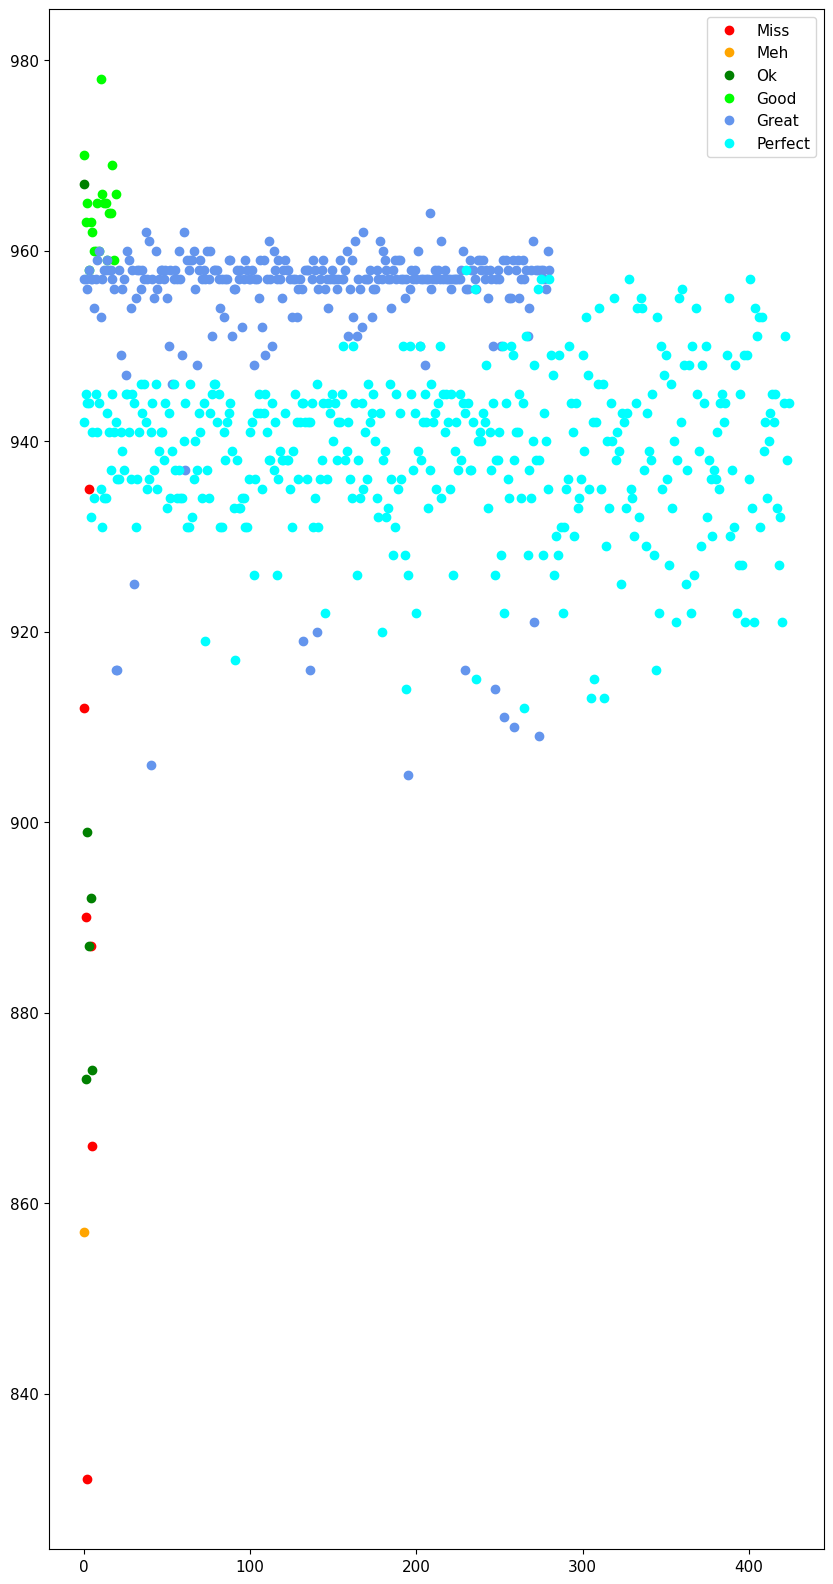

In [12]:
hit_type_dict = {
  0 : 'Miss',
  1 : 'Meh',
  2 : 'Ok',
  3 : 'Good',
  4 : 'Great',
  5 : 'Perfect',
}

hit_type_colors ={
  0 : 'red',
  1 : 'orange',
  2 : 'green',
  3 : 'lime',
  4 : 'cornflowerblue',
  5 : 'aqua',
}

hit_type_locs = [0] * 6
hit_res = [0] * 6
combined = [] 

for i in range(len(frames)):  
  if sum(t_hit_type[i]) > -4:
    #print(t_frames[i], actions[i], t_hit_type[i])
    for h in t_hit_type[i]:
      if h not in [-1, 6, 7]:
        hit_res[h] += 1
    
    combined.append((t_frames[i][0], keys[i], t_hit_type[i]))

combined = np.array(combined)
outlier_thresh = 0.75
remove_count = 0

import matplotlib.pyplot as plt
for i in range(6):
  filter = [x for x in combined if i in x[2] and x[0][0] == 1 and 800 < x[0][2] < 1000]
  temp = []
  
  for f in filter:
    point = f[0][2]
    temp.append(point.item())
  
  std = np.std(temp)
  mean = np.mean(temp)
  
  for x in temp:
    z = abs(x - mean)/std
    if z > outlier_thresh:
      remove_count += 1
      temp.remove(x)
  
  hit_type_locs[i] = temp

print(f'Removed {remove_count} outliers')
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 20))
for i in range(len(hit_type_locs)):
  ax.plot(hit_type_locs[i], label=hit_type_dict[i], marker='o', linestyle='None', color=hit_type_colors[i])
  print(f'Average {hit_type_dict[i]}: {np.mean(hit_type_locs[i])}')
  
ax.legend()
plt.show()
    
  # print(len(filter))
  # hit_type_max[i].append(max(filter, key=lambda x: x[0][2]))
  # hit_type_min[i].append(min(filter, key=lambda x: x[0][2]))

In [13]:
print(min(hit_type_locs[5]))
print(max(hit_type_locs[5]))

print(min(hit_type_locs[4]))
print(max(hit_type_locs[4]))

912
958
905
964


In [14]:
def saveData(name):
    os.makedirs('./expert_demo', exist_ok=True)

    data = {"frame": frames,
            "action": keys,
            "hit_type": hit_type}
    
    torch.save(data, f"./expert_demo/{name}_{time.time()}.pth")

In [15]:
#saveData("replay")

In [16]:
#test in game
# song_begin = False
# while listener.is_listening or listener.is_first_connection:
#     if listener.has_connection:
#         song_begin = True
#         time_start = time.time()
#         vision_thread = executor.submit(capture, region)
#         image = vision_thread.result()

#         vision_thread = executor.submit(detect, np.array(image), model)
#         notes = vision_thread.result() 
        
#         perform_action(actions[i])

#         elapsed_time = time.time() - time_start
#         if elapsed_time < frame_duration:
#                 time.sleep(frame_duration-elapsed_time)

#     elif song_begin:
#          break